In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing HSPCs with the TemporalProblem

In this tutorial, we show how to use the TemporalProblem to analyze the trajectory of HSPC cells.



## Description of the dataset

The dataset is an extraction of the *Open Problems - Multimodal Single-Cell Integration* NeurIPS competition 2022. 

Cell type annotation was done based on *only* gene expression. Moreover, the annotation is very coarse, resulting in 

- MasP = Mast Cell Progenitor
- MkP = Megakaryocyte Progenitor
- NeuP = Neutrophil Progenitor
- MoP = Monocyte Progenitor
- EryP = Erythrocyte Progenitor
- HSC = Hematoploetic Stem Cell
- BP = B-Cell Progenitor

ATAC-seq peakk counts were transformed with `TF-IDF` (`log(TF) * log(IDF)`)

## Importing packages and loading the data

In [14]:
import numpy as np
import scanpy as sc
from sklearn.preprocessing import StandardScaler

from moscot.problems.time import TemporalProblem
from moscot.datasets import hspc
import moscot.plotting as mpl


In [2]:
adata = hspc()
adata

100%|██████████| 126M/126M [00:25<00:00, 5.24MB/s] 


AnnData object with n_obs × n_vars = 4000 × 2000
    obs: 'day', 'donor', 'cell_type', 'technology', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'neighbors', 'neighbors_atac', 'pca', 'umap'
    obsm: 'X_lsi', 'X_pca', 'X_umap_ATAC', 'X_umap_GEX', 'peaks_tfidf'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neighbors_atac_connectivities', 'neighbors_atac_distances'

In [3]:
adata.obs["day"].unique()

array([2, 3, 4, 7])

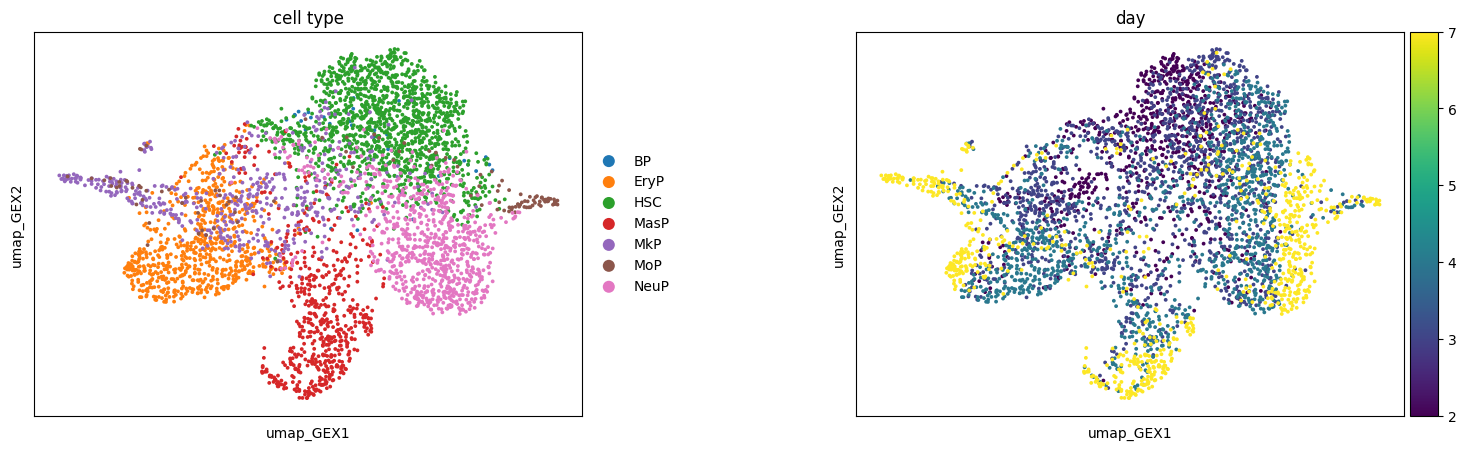

In [4]:
sc.pl.scatter(adata, basis="umap_GEX", color=["cell_type", "day"])

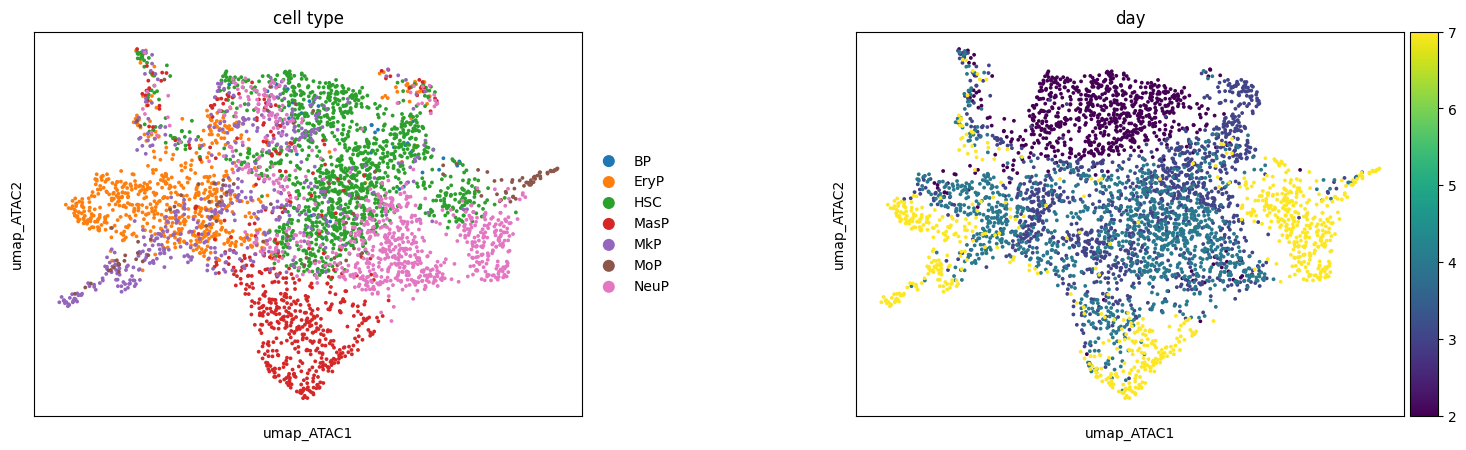

In [5]:
sc.pl.scatter(adata, basis="umap_ATAC", color=["cell_type", "day"])

As we want to leverage information from both modalities, we need to find a shared space of GEX and ATAC. There are different ways to obtain this, e.g. via MultiVI (cite). Here, we simply concatenate the PCA-reduced GEX space and the LSI-reduced ATAC space.

As we want both modalities to have a comparable influence on the coupling, we need to make sure that the total variances are comparable.

In [18]:
np.var(adata.obsm["X_lsi"]), np.var(adata.obsm["X_pca"])

(1.0000002, 39.049347)

While the LSI space was standard-normalized in the course of preprocessing, this does not hold for PCA space. Hence, we standard-normalize the PCA embedding.

In [16]:
adata.obsm["X_pca_scaled"] = StandardScaler().fit_transform(adata.obsm["X_pca"])

In [19]:
adata.obsm["X_shared"] = np.concatenate((adata.obsm["X_pca_scaled"], adata.obsm["X_lsi"]), axis=1)

In [20]:
tp = TemporalProblem(adata)
tp = tp.score_genes_for_marginals(gene_set_proliferation="human", gene_set_apoptosis="human")
tp = tp.prepare(time_key="day", joint_attr="X_shared")

/Users/dominik.klein/opt/anaconda3/envs/moscot_env3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Users/dominik.klein/opt/anaconda3/envs/moscot_env3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


We investigate the proliferation and apoptosis markers on the UMAP. Proliferation markers are much stronger than apoptosis markers. This is to be expected as we are in a developmental setting.

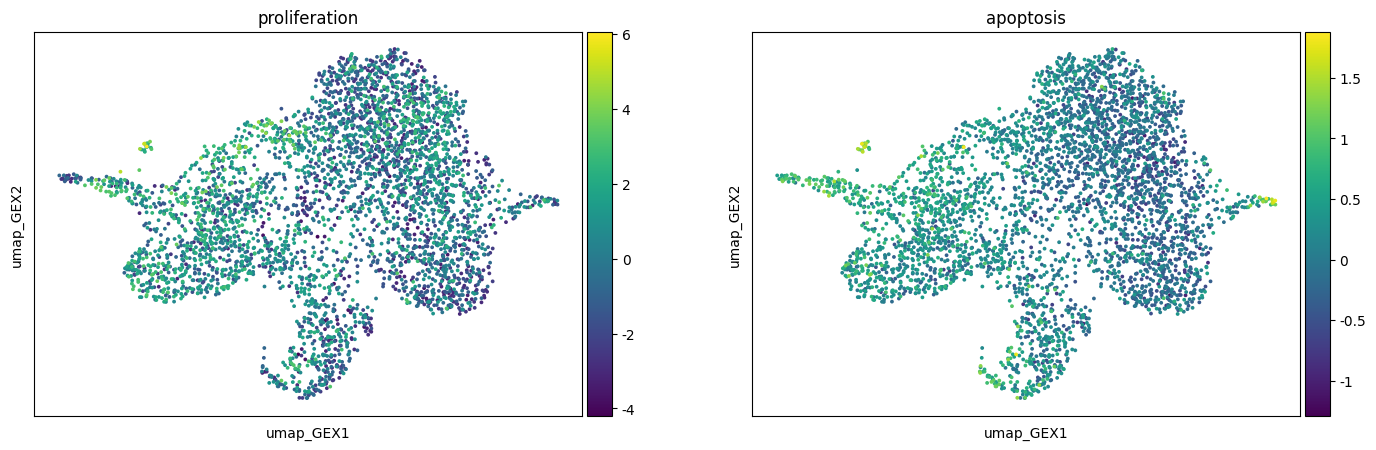

In [21]:
sc.pl.scatter(adata, basis="umap_GEX", color=["proliferation", "apoptosis"])

In [26]:
tp = tp.solve(tau_a=0.99, tau_b=1, scale_cost="mean", max_iterations=1e5)

In [13]:
tp.growth_rates

/Users/dominik.klein/opt/anaconda3/envs/moscot_env3/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'OTSolver.parameters' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


AttributeError: 'BirthDeathProblem' object has no attribute '_src_obs_mask'

In [ ]:

adata.obs["caell_costs_source"] = np.abs(tp.cell_costs_source)
adata.obs["cell_costs_target"] = np.abs(tp.cell_costs_target)

In [14]:
import numpy as np
adata.obs["cell_costs_source"] = np.abs(tp.cell_costs_source)
adata.obs["cell_costs_target"] = np.abs(tp.cell_costs_target)

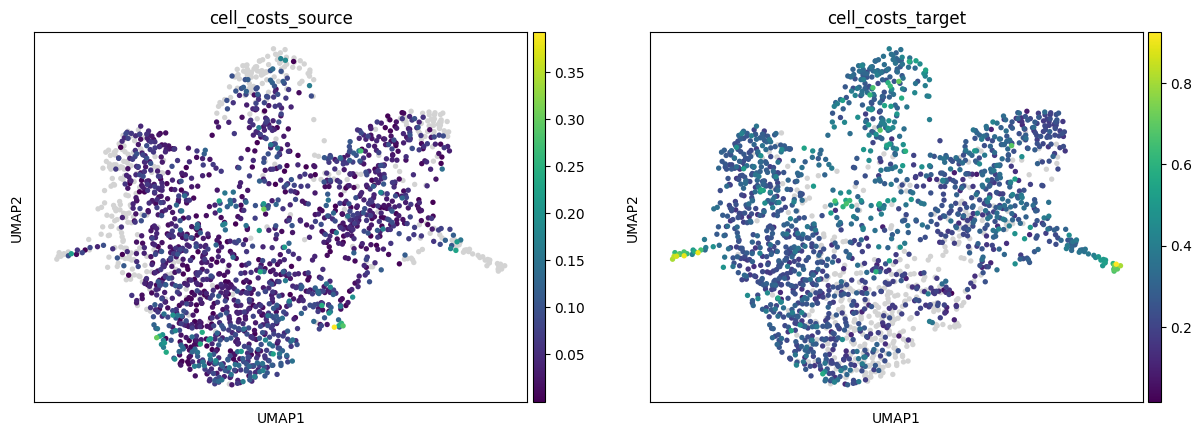

In [15]:
sc.pl.umap(adata, color= ["cell_costs_source", "cell_costs_target"])

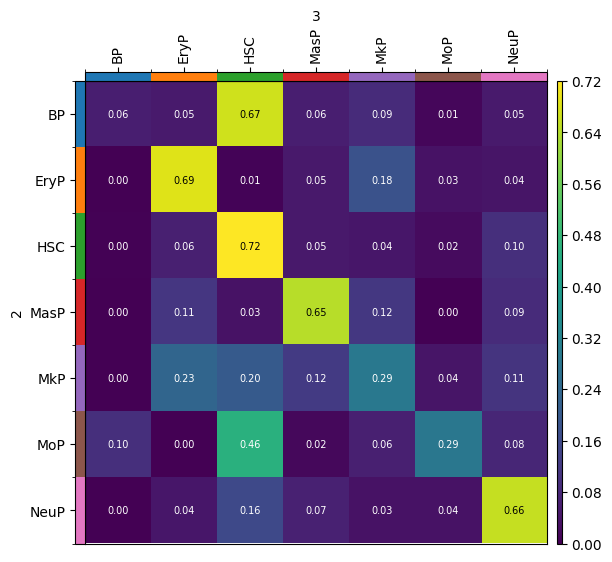

In [25]:
ct_desc = tp.cell_transition(2,3, "cell_type", "cell_type", forward=True)
mpl.cell_transition(tp, dpi=100)

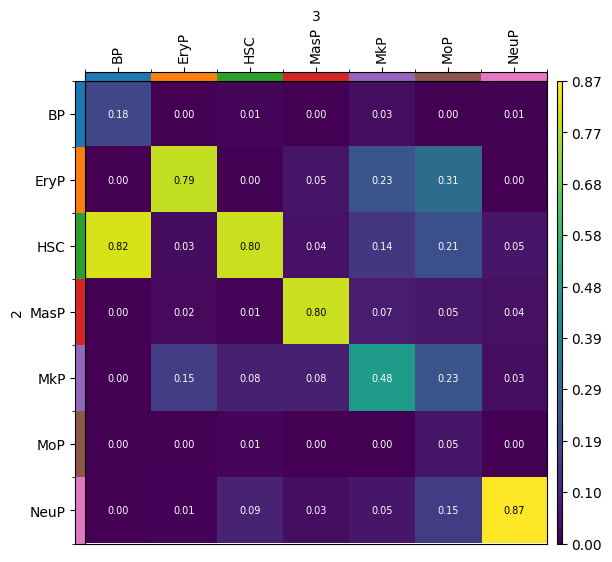

In [17]:
ct_anc = tp.cell_transition(2,3, "cell_type", "cell_type", forward=False)
mpl.cell_transition(tp)

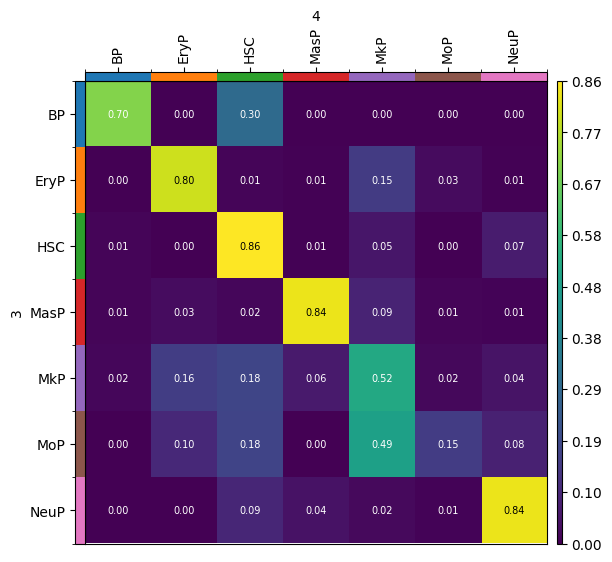

In [18]:
ct_desc = tp.cell_transition(3,4, "cell_type", "cell_type", forward=True)
mpl.cell_transition(tp)

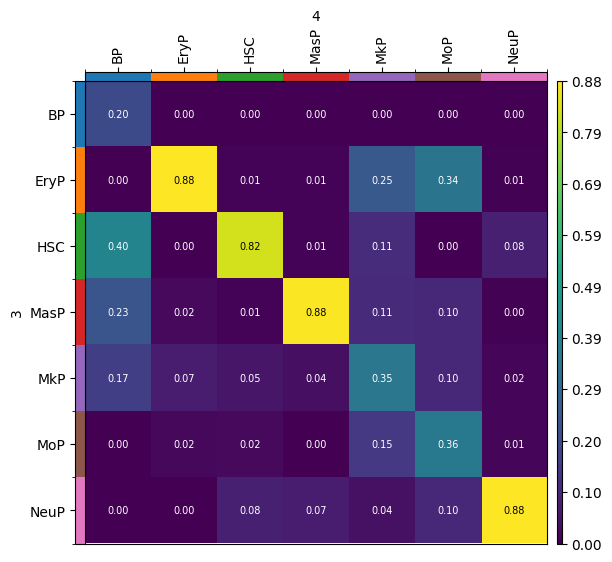

In [19]:
ct_anc = tp.cell_transition(3,4, "cell_type", "cell_type", forward=False)
mpl.cell_transition(tp)

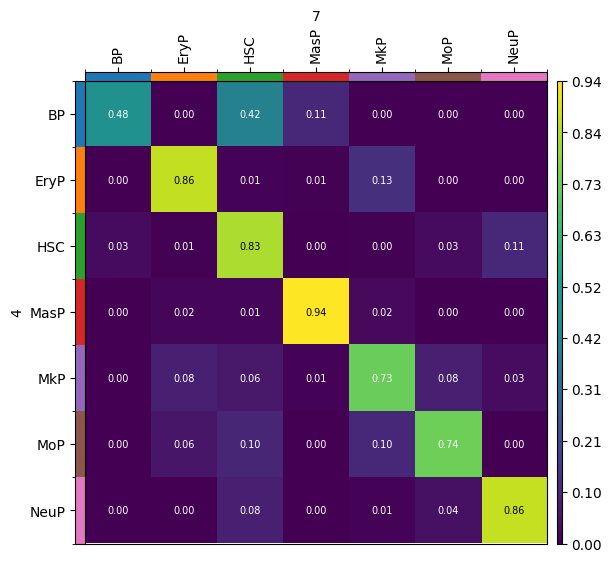

In [20]:
ct_anc = tp.cell_transition(4,7, "cell_type", "cell_type", forward=True)
mpl.cell_transition(tp)

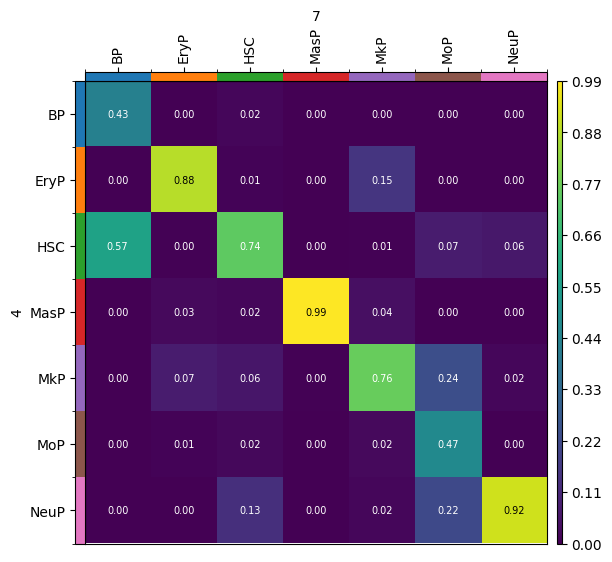

In [21]:
ct_anc = tp.cell_transition(4,7, "cell_type", "cell_type", forward=False)
mpl.cell_transition(tp)

In [12]:
adata.uns["moscot_results"]["cell_transition"]

{'cell_transition': {'transition_matrix':                         BP           HSC          MasP          NeuP  \
  cell_id                                                                
  9d9116b806de  0.000000e+00  1.000000e+00  0.000000e+00  8.744394e-21   
  18f1b5233585  0.000000e+00  1.944819e-10  2.915896e-29  0.000000e+00   
  baee66c58929  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
  3a4a94c6e237  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  b153c6f7488c  0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
  ...                    ...           ...           ...           ...   
  5209bfcf1371  0.000000e+00  2.127785e-01  0.000000e+00  7.872215e-01   
  af51e9f4af98  1.034887e-35  1.000000e+00  0.000000e+00  0.000000e+00   
  4e5b45ea4549  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
  5b35df012366  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
  321744b37b5c  0.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00  

In [ ]:
tp2 = TemporalProblem(adata)
tp2 = tp2.prepare("day", policy="explicit", subset=[(2,4)])
tp2 = tp2.solve(tau_a=0.99, tau_b=1)
tp = tp.add_problem(key=(2,4), problem=tp2[(2,4)])


tp.compute_interpolated_distance(start=2, intermediate=3, end=4)
tp.compute_random_distance(start=2, intermediate=3, end=4)

In [11]:
ct_anc = tp.cell_transition(2,7, "cell_type", "cell_type", forward=True, online=True)


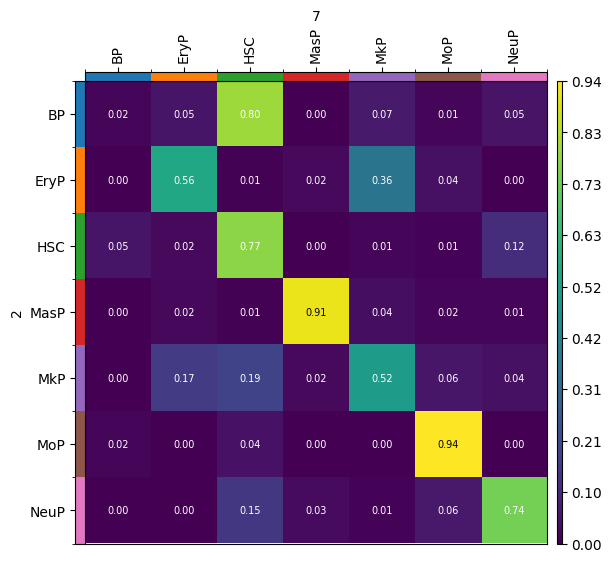

In [12]:
mpl.cell_transition(tp)